# PC Gradients

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math_operations import *
from PCUnit import *
from PCConx import *
from PCNet import *
from copy import deepcopy
%load_ext autoreload
%autoreload 2

In [2]:
import torch

## Mathematical Operations
These classes are used by the PC network to implement various activation functions. Each class can also compute its derivative.

Many of these operations do not need an object instantiation; you can compute the $\sin$ without having to store anything. As such, these classes do not have an `__init__` function, and its methods are `@classmethod`s, which means they are generic to the class (not attached to an object).

The exceptions are the classes `scalarmult` and `scaledlogistic`, in which the operation is multiplied by a scalar. That scalar has to be stored somewhere, so those classes DO instantiate an object that stores the scalar.

Does that make sense?

See below for how to use it.

In [3]:
myfunc = square()   # This creates an object of class "square"
print(myfunc)       # Prints the function class
print(myfunc(3.))   # This calls the function
print(myfunc.D(3.))   # This computes its derivative.

square
9.0
6.0


In [4]:
# Another example
myfunc2 = scaledlogistic(-2.)
print(myfunc2(10.))
print(myfunc2.D(10.))

-1.9999092042625952
-9.079161547181531e-05


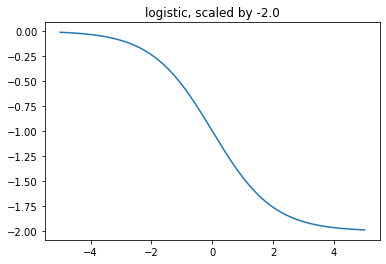

In [5]:
# Plot it
x = np.linspace(-5, 5, 200)
plt.plot(x, myfunc2(x))
plt.title(myfunc2);

## `PCUnit`
This class represents the value-node and error-node together, into what I call a "unit".



In [6]:
v0 = PCUnit()
print(v0.v)
print(v0.tau)
print(v0.clamp_v)

[0.]
0.02
False


In [7]:
v0.v_receive(10.)  # add some input current
v0.step(dt=0.001)  # Euler step
print(v0.v)  # should be 0.5, since dt/tau*10 = 0.001/0.02*10 = 0.5

[0.5]


In [8]:
v0.v_receive(10.)  # more input current
v0.clamp_v = True  # this time, we'll clamp it
v0.step()          # Euler step
print(v0.v)        # no change, since it's clamped

[0.5]


## `PCConx`
This class represents connections between `PCUnit`s.

In [9]:
v0 = PCUnit()
v1 = PCUnit()
conx = PCConx(v0, v1, func=sqrt())
v0.v[0] = 4.
print(v1.de)  # no input to v1.e yet
conx.send()   # v0 and v1 exchange current through conx
print(v1.de)  # should be -sqrt(4)

[0.]
[-2.]


## `PCNet`
Puts together multiple `PCUnit`s with `PCConx`s.

In [10]:
# This function is handy for printing the output from
#  ts, u = net.run()
def plot_PC(ts, u):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    for uu in u[:]:
        plt.plot(ts, uu[0])
    plt.title('Error nodes')
    plt.subplot(1,2,2)
    for uu in u[:]:
        plt.plot(ts, uu[1])
    plt.title('Value nodes: top = '+str(net.unit[-1].v[0]));

## Sample PC Code
Here is how you can build a PCNet and run it.

In [14]:
net = PCNet()  # Create the PCNet
v0 = PCUnit(bottom=True)  # Create a (bottom) PCUnit
# Note that the error node of a bottom unit is clamped by default.
net.add_unit(v0)  # Add the PCUnit to the net
v1 = PCUnit()  # Another PCUnit
net.add_unit(v1)
net.connect(v0, v1, func=logistic())

logistic


In [15]:
# Here is how you can access the units in the PCNet
net.unit[0].v   # this is v0

array([0.])

In [16]:
# And here is how you can access the connections
net.conx[0].func

logistic

In [17]:
v0.v[0] = 4.  # Set the bottom input
v0.clamp_v = True  # Clamp it
ts, us = net.run(1.)   # Run it for 1 second

In [18]:
# Look at the state of the PCNet
net

[ e[0.] == v[4.] ]
[ e[-1.1956423e-11] == v[0.98201379] ]

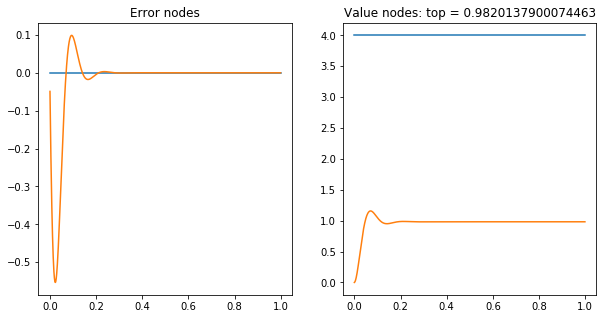

In [19]:
# Plot the output from the run
plot_PC(ts, us)

## Two nodes projecting to each other
This is experimental; my first attempt at a fully recurrent PC network.

In [30]:
net = PCNet()  # Create the PCNet
v0 = PCUnit(); net.add_unit(v0)  # Create and add a PCUnit
v1 = PCUnit(); net.add_unit(v1)  # another PCUnit
M0 = 2.
M1 = 4.
#net.connect(v0, v1, func=scalarmult(M0))
#net.connect(v1, v0, func=scalarmult(M1))
net.set_tau(0.05)
net.connect(v0, v1, func=scaledlogistic(1.))
net.connect(v1, v0, func=scaledlogistic(2.))

logistic, scaled by 1.0
logistic, scaled by 2.0


In [31]:
net.randomize_state()
print(net)
ts, us = net.run(5., dt=0.001)
net

[ e[-0.65835904] == v[-0.15657022] ]
[ e[1.27271089] == v[-0.3230501] ]



[ e[4.55338178e-15] == v[1.37948157] ]
[ e[1.16736716e-15] == v[0.79890773] ]

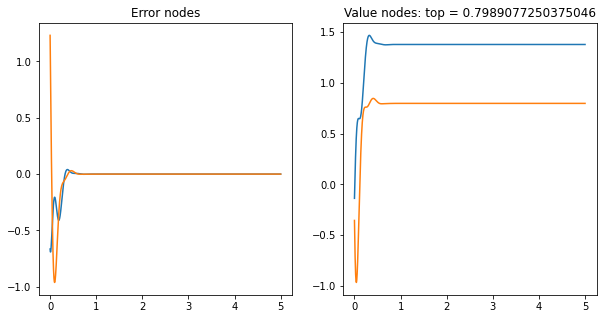

In [32]:
plot_PC(ts, us)

### Stability of equilibrium at $[0,0,0,0]$

Recall the system of DEs,
$$
\begin{align}
\tau \dot{\varepsilon_0} &= v_0 - M_1 \sigma (v_1) - \varepsilon_0 \\
\tau \dot{\varepsilon_1} &= v_1 - M_0 \sigma (v_0) - \varepsilon_1 \\
\tau \dot{v_0} &= M_0 \varepsilon_1 \sigma' (v_0) - \varepsilon_0 \\
\tau \dot{v_1} &= M_1 \varepsilon_0 \sigma' (v_1) - \varepsilon_1
\end{align}
$$

In [28]:
# Jacobian at [0,0,0,0]
M = np.array([[-1, 0, 1, -M1],
              [0, -1, -M0, 1],
              [-1, M0, 0, 0],
              [M1, -1, 0, 0]])

In [28]:
# Jacobian at [0,0,0,0]
M = np.array([[-1, 0, 1, -M1],
              [0, -1, -M0, 1],
              [-1, M0, 0, 0],
              [M1, -1, 0, 0]])

In [29]:
# The real parts of the eigenvalues are all <0
np.linalg.eig(M)[0]

array([-0.5 +3.90586918j, -0.5 -3.90586918j, -0.5+20.05602618j,
       -0.5-20.05602618j])

## Millidge & Tschantz test case
Reproduces the results in their paper.

In [27]:
net = PCNet()
v0 = PCUnit(bottom=True); net.add_unit(v0)  # input node
v1 = PCUnit(); net.add_unit(v1)  # \  top branch
v2 = PCUnit(); net.add_unit(v2)  # /
v3 = PCUnit(); net.add_unit(v3)  # > bottom branch
v4 = PCUnit(); net.add_unit(v4)  # output
net.connect(v0, v1, func=scalarmult(2.))
net.connect(v1, v2, func=sqrt())
net.connect(v2, v4, func=tan())
net.connect(v0, v3, func=square())
net.connect(v3, v4, func=sin())

multiply by 2.0
sqrt
tan
square
sin


In [28]:
# This is the function that the above implements.
def MTfunc(v0):
    return np.tan(np.sqrt(np.abs(2.*v0))) + np.sin(v0**2)

In [29]:
# Clamp input
v0.v = np.array([5.])
v0.clamp_v = True
# ... and set the rest of the network close to the equilibrium
net.unit[1].v[0] = 10.
net.unit[2].v[0] = 3.
net.unit[3].v[0] = 25.
net.unit[4].v[0] = 0.

In [30]:
# Simulate the network
ts, u = net.run(1.)

[ e[0.] == v[5.] ]
[ e[2.04600878e-12] == v[10.] ]
[ e[-3.94529352e-11] == v[3.16227766] ]
[ e[-4.15679937e-11] == v[25.] ]
[ e[1.10414874e-10] == v[-0.11166379] ]

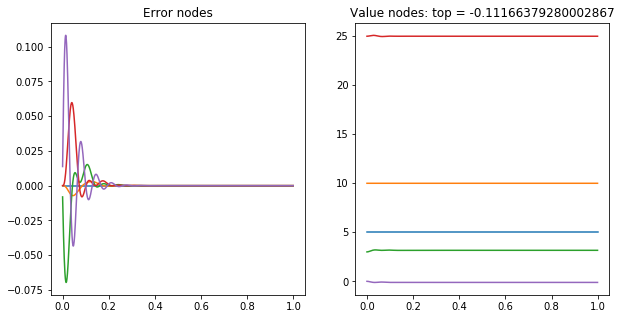

In [31]:
# And observe the output
plot_PC(ts, u)
net

### Error gradients
These demonstrations are how we match the results of Millidge & Tschantz.

- Clamp both sides
- Fix $\mu$-values after initial pass (as M&T do)
- Top gradient is $\mu - T$

In [32]:
T = 1  # target for top layer
net.fix_mu()  # store current v-values in corresponding mu's

In [33]:
# We also have to clamp the top error
net.unit[-1].clamp_e = True
net.unit[-1].e[0] = -(net.unit[-1].v[0] - T)  # TOP ERROR USES MU

In [34]:
# clamp top and bottom
net.unit[0].v = np.array([5.])
net.unit[-1].v = np.array([1.])
net.unit[0].clamp_v = True
net.unit[-1].clamp_v = True

In [35]:
ts, us = net.run(1.)

[ e[0.] == v[5.] ]
[ e[0.17584471] == v[10.17584471] ]
[ e[1.11213958] == v[4.27441724] ]
[ e[1.10188428] == v[26.10188428] ]
[ e[1.11166379] == v[1.] ]

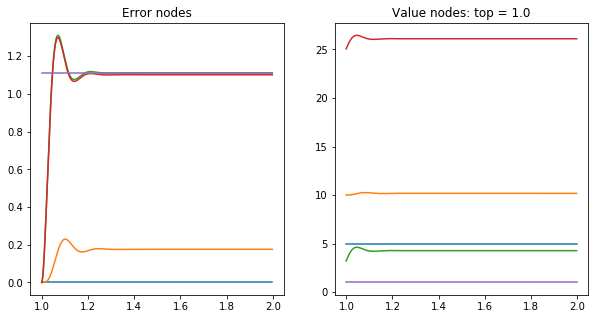

In [36]:
# Errors (gradients) should all be close to zero
plot_PC(ts, us)
net

In [37]:
for u in net.unit:
    print(u.mu)

[5.]
[10.]
[3.16227766]
[25.]
[-0.11166379]


## Using $v$ instead of $\mu$
However, if we run the same network as a dynamical system (ignoring the $\mu$-values), we get different results.

In [38]:
net.unit[1].v[0] = 10.
net.unit[2].v[0] = 3.
net.unit[3].v[0] = 25.
net.unit[4].v[0] = 1.

In [39]:
net.release_mu()   # tells it not to use the mu-values
net.unit[-1].clamp_e = False  # and compute the top error dynamically
ts, us = net.run(1.)

In [40]:
net

[ e[0.] == v[5.] ]
[ e[0.06446739] == v[10.06446739] ]
[ e[0.40903967] == v[3.58149413] ]
[ e[0.32846733] == v[25.32846733] ]
[ e[0.33486098] == v[1.] ]

In [41]:
net

[ e[0.] == v[5.] ]
[ e[0.06446739] == v[10.06446739] ]
[ e[0.40903967] == v[3.58149413] ]
[ e[0.32846733] == v[25.32846733] ]
[ e[0.33486098] == v[1.] ]

In [42]:
ts, u = net.run(1.)

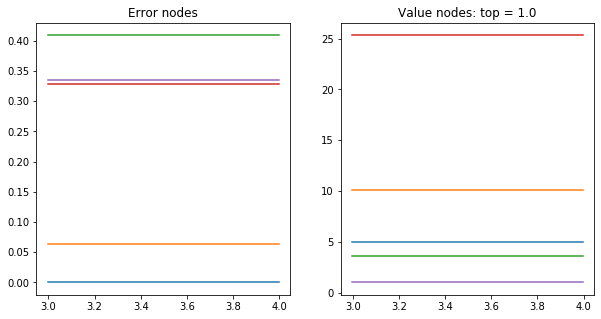

In [43]:
plot_PC(ts, u)

In [44]:
net

[ e[0.] == v[5.] ]
[ e[0.06446739] == v[10.06446739] ]
[ e[0.40903969] == v[3.58149416] ]
[ e[0.32846735] == v[25.32846735] ]
[ e[0.33486095] == v[1.] ]

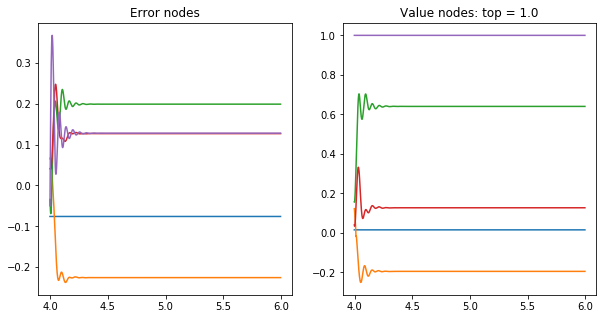

In [45]:
net.randomize_state(noise=0.1)
for u in net.unit:
    u.v = np.abs(u.v)
net.unit[-1].v = np.array([1.])
ts, u = net.run(2.)
plot_PC(ts, u)

In [46]:
net

[ e[-0.07589518] == v[0.01547321] ]
[ e[-0.22563005] == v[-0.19468364] ]
[ e[0.19910936] == v[0.64033905] ]
[ e[0.12699883] == v[0.12723825] ]
[ e[0.12803384] == v[1.] ]

In [47]:
MTfunc(net.unit[0].v[0])

0.17799274301703324